In [8]:
# data processing
import numpy as np
import os
import sys
import pandas as pd
import pickle

# Machine learning library
import h2o
from h2o.automl import H2OAutoML
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, roc_curve, auc

# data visualizations
import matplotlib.pyplot as plt
import seaborn as sns


In [9]:
# Processing configuration
class Location:
    """Specify the locations of inputs and outputs"""

    # Get the path of the directory containing the script file
    script_dir = os.path.dirname(os.path.abspath(sys.path[0]))

    # Navigate up to the top-level directory
    src_level_dir = os.path.dirname(script_dir)

    top_level_dir = os.path.dirname(src_level_dir)

    # Define the relative path to the data directory
    data_dir = os.path.join(top_level_dir, "AutomatingAnalysisModelsAndMisprediction\\data")

    data_raw: str = f"{data_dir}\\raw\\creditcard.csv"
    data_process: str = f"{data_dir}\\processed\\creditcard.pkl"
    
    
class ProcessConfig:
    """Specify the parameters of the `process` flow"""

    label: str = "Class"
    test_size: float = 0.2

In [10]:
# Processing functions
def getProcessedData(file_path: str):
    # read python dict back from the file
    with open(file_path, 'rb') as f:
        split_dict = pickle.load(f)

    X_train = split_dict["X_train"]
    X_test = split_dict["X_test"]
    y_train = split_dict["y_train"]
    y_test = split_dict["y_test"]
    return X_train, X_test, y_train, y_test

def getUnprocessedData(url: str):
    dataset = pd.read_csv(url)
    return dataset

In [11]:
# Get unprocessed data
dataset = getUnprocessedData(Location.data_raw)
dataset.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [12]:
# get the data
X_train, X_test, Y_train, Y_test = getProcessedData(Location.data_process)
Y_train.values.reshape(-1, 1)


array([[1],
       [1],
       [1],
       ...,
       [1],
       [0],
       [0]], dtype=int64)

In [13]:
# Standardize features. Require for Machine learning
sc = StandardScaler()
# Fit to data, then transform it
X_train = sc.fit_transform(X_train)
sc.mean_


array([ 8.77610247e+04, -2.46262349e+00,  1.90800808e+00, -3.63171632e+00,
        2.31983283e+00, -1.62303115e+00, -7.15305538e-01, -2.91204708e+00,
        2.79271174e-01, -1.32632788e+00, -2.89654820e+00,  1.93151200e+00,
       -3.18705258e+00, -4.84921519e-02, -3.56155548e+00, -4.79195526e-02,
       -2.10382143e+00, -3.39328851e+00, -1.14366338e+00,  3.47389397e-01,
        1.82343707e-01,  3.96481163e-01, -8.68766725e-03, -3.33574126e-03,
       -5.44175581e-02,  2.68096303e-02,  2.79480259e-02,  8.07179774e-02,
        4.15831979e-02,  9.54182964e+01])

In [14]:
sc.scale_

array([4.81160825e+04, 5.42511821e+00, 3.61581329e+00, 6.13021968e+00,
       3.13900344e+00, 4.11528398e+00, 1.70391851e+00, 5.68343127e+00,
       4.91834456e+00, 2.22049461e+00, 4.39573218e+00, 2.69638811e+00,
       4.49633794e+00, 9.96227885e-01, 4.53188596e+00, 9.22015397e-01,
       3.35926413e+00, 5.74923103e+00, 2.30950632e+00, 1.17490154e+00,
       1.02686804e+00, 2.82681317e+00, 1.15801192e+00, 9.99902390e-01,
       5.39006604e-01, 6.10783267e-01, 4.47642217e-01, 9.47536789e-01,
       4.17012856e-01, 2.20512879e+02])

In [15]:
# Perform standardization by centering and scaling
X_test = sc.transform(X_test)
X_test

array([[-1.66737576,  0.48063529,  0.58510239, ...,  0.6155468 ,
         1.00930167, -0.42817588],
       [-1.66362097,  0.62478995,  0.09435604, ...,  0.34975227,
         0.07436826, -0.42817588],
       [-1.73526232,  0.29688382, -0.26894505, ..., -0.08551566,
        -0.39968413, -0.2942608 ],
       ...,
       [-1.0779346 , -0.05472458,  0.56866972, ...,  1.16328888,
         1.45891586, -0.42457375],
       [-1.22754827, -4.9439327 ,  3.94993962, ...,  1.2612911 ,
         0.79093953,  0.02073214],
       [ 1.60308095,  0.83660383, -0.5056216 , ..., -0.09410373,
        -0.1932741 , -0.35765846]])

In [16]:
# Init an H2O cluster
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,21 hours 55 mins
H2O_cluster_timezone:,Asia/Jerusalem
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.1
H2O_cluster_version_age:,18 days
H2O_cluster_name:,H2O_from_python_Administrator_71jcrd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.007 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [17]:
# Convert training data to H2OFrame
# the train result will be used to train a machine learning model
train = h2o.H2OFrame(np.concatenate((X_train, Y_train.values.reshape(-1, 1)), axis=1))
train.columns = list(dataset.columns)
train[ProcessConfig.label] = train[ProcessConfig.label].asfactor()

# Specify target variable and predictor variables
x = train.columns[:-1]
y = train.columns[-1]


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [58]:
# Run H2O AutoML to automatically select, train and optimize SVM model
aml = H2OAutoML(max_models=10, sort_metric='mse', max_runtime_secs=5 * 60, seed=666)
aml.train(x=x, y=y, training_frame=train)

AutoML progress: |█
11:32:27.484: AutoML: XGBoost is not available; skipping it.

██████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_1_AutoML_5_20230226_113225


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    175                175                         867334                 15           15           15            163           630           389.4

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 4.392848744325828e-08
RMSE: 0.00020959123894680876
LogLoss: 1.0161279671721936e-05
Mean Per-Class Error: 0.0
AUC: 1.0
AUCPR: 1.0
Gini: 1.0

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.9680477740380192
       0       1       Error    Rate
-----  ------  ------  -------  --------------
0      159558  0       0        (0.0/159558.0)
1      0       159022  0        (0.0/159022.0)
Total  159558  159022  0        (0.0/318580.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value    idx
---------------------------  -----------  -------  -----
max f1                       0.968048     1        177
max f2                       0.968048     1        177
max f0point5                 0.968048     1        177
max accuracy                 0.968048     1        177
max precision                1            1        0
max recall                   0.968048     1        177
max specificity              1            1        0
max absolute_mcc             0.968048     1        177
max min_per_class_accuracy   0.968048     1        177
max mean_per_class_accuracy  0.968048     1        177
max tns                      1            159558   0
max fns                      1            101631   0
max fps                      3.17643e-07  159558   399
max tps                      0.968048     159022   177
max tnr                      1            1        0
max fnr                      1            0.6391   0
max fpr                      3.17643e-07  1        399
max tpr                      0.968048     1        177

Gains/Lift Table: Avg response rate: 49.92 %, avg score: 49.92 %
group    cumulative_data_fraction    lower_threshold    lift     cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  -------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------  --------------------
1        0.0100006                   1                  2.00337  2.00337            1                1            1                           1                   0.020035        0.020035                   100.337  100.337            0.020035
2        0.0200013                   1                  2.00337  2.00337            1                1            1                           1                   0.020035        0.0400699                  100.337  100.337            0.0400699
3        0.0300019                   1                  2.00337  2.00337            1                1            1                           1                   0.020035        0.0601049                  100.337  100.337            0.0601049
4        0.0400025                   1                  2.00337  2.00337            1                1            1                           1                   0.020035        0.0801399                  100.337  100.337            0.0801399
5        0.05                        1                  2.00337  2.00337            1                1            1                           1                   0.0200287       0.100169             

In [59]:
# View the leaderboard of trained models
lb = aml.leaderboard
print(lb.head())

model_id                                mse       auc      logloss     aucpr    mean_per_class_error        rmse
GBM_1_AutoML_5_20230226_113225  9.85582e-05  0.999992  0.000744199  0.999992             6.56915e-05  0.00992765
DRF_1_AutoML_5_20230226_113225  0.000409968  0.999968  0.0049416    0.999934             8.75887e-05  0.0202477
GLM_1_AutoML_5_20230226_113225  0.0215062    0.995761  0.0794782    0.996414             0.0262649    0.14665
[3 rows x 7 columns]



In [60]:
# Use the best model to predict on test data
model = aml.leader
X_h2o = h2o.H2OFrame(X_test)
X_h2o.columns = list(dataset.columns)[:-1]
y_pred = model.predict(X_h2o).as_data_frame().values.flatten()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [61]:
# Train a PySVM SVM model
model = LinearSVC(random_state=0, tol=1e-5, max_iter=10000, dual=False)
Y_pred = model.fit(X_train, Y_train)

In [62]:
# fig, ax = plt.subplots(figsize=(8,5))
# sns.scatterplot(Y_pred, y[ProcessConfig.label] ,ax=ax)
# sns.lineplot(Y_pred,Y_pred,ax=ax,color='black')
# ax.set_xlabel(ProcessConfig.label)

In [63]:
# Test the model on the test data
y_pred = model.predict(X_test)
misclassified = np.where(Y_test != y_pred)[0]
print("Indices of potentially misclassified instances: ", misclassified)

Indices of potentially misclassified instances:  [    11    125    194 ... 113624 113685 113697]


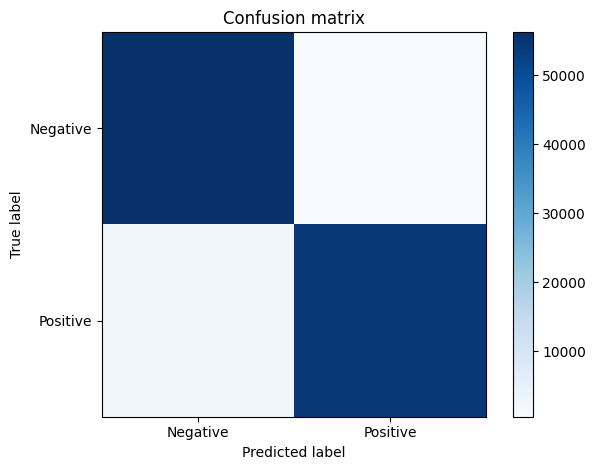

In [64]:
# Confusion matrix - summarizing the performance of a classification algorithm.
cm = confusion_matrix(Y_test, y_pred)
plt.figure()
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks([0, 1], ["Negative", "Positive"])
plt.yticks([0, 1], ["Negative", "Positive"])
plt.tight_layout()
plt.show()

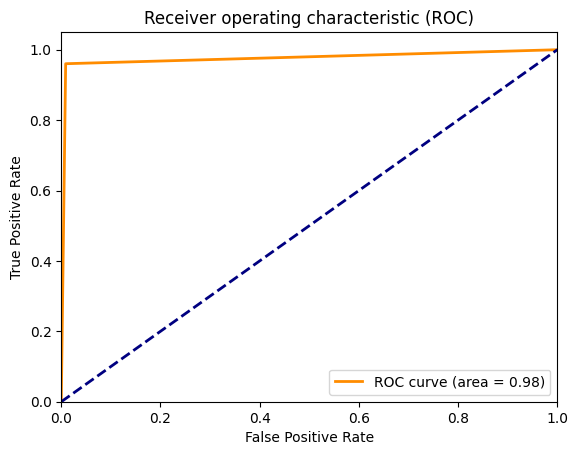

In [65]:
# ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic (ROC)")
plt.legend(loc="lower right")
plt.show()